In [71]:
!nvidia-smi

Fri Feb 21 18:33:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0             11W /   70W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
%%capture
!pip install torch
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
import os

# Check if the file already exists
file_path = "C:/Users/darsh/OneDrive/Desktop/ai-recipe-generator-image-ingrediants/eval/content/test-5000.csv"
if not os.path.exists(file_path):
    # If the file does not exist, copy it from the local path
    shutil.copy("C:/Users/darsh/OneDrive/Desktop/ai-recipe-generator-image-ingrediants/eval/test-5000.csv", file_path)
else:
    print(f"File already exists at {file_path}")

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [14]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import os
import json

import torch
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

c:\Users\darsh\anaconda3\envs\chef\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model_name_or_path = "flax-community/t5-recipe-generation"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model_name_or_path, device)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path).to(device)

flax-community/t5-recipe-generation cpu


In [16]:
prefix = "items: "
genkw = {
    "max_length": 512,
    "min_length": 64,
    "no_repeat_ngram_size": 3,
    "do_sample": True,
    "top_k": 60,
    "top_p": 0.95,
    "num_return_sequences": 5
}

In [19]:
dataset = load_dataset("csv", data_files={"test": "C:/Users/darsh/OneDrive/Desktop/ai-recipe-generator-image-ingrediants/eval/content/test-5000.csv"}, delimiter="\t")["test"]
dataset

Generating test split: 5000 examples [00:00, 102589.35 examples/s]


Dataset({
    features: ['inputs', 'targets'],
    num_rows: 5000
})

In [20]:
def predict(batch):
    inputs = [prefix + inp for inp in batch["inputs"]]

    inputs = tokenizer(
        inputs, 
        max_length=256, 
        padding=True, 
        truncation=True, 
        return_tensors='pt'
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            **genkw
        )

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    batch["predicted"] = [outputs[i:i + genkw["num_return_sequences"]] for i in range(0, len(outputs), genkw["num_return_sequences"])]
    return batch

In [21]:
# OR You can pass this step
#!curl -c "https://raw.githubusercontent.com/chef-transformer/chef-transformer/main/data/ChefTransformer_predicted.json" /content/predicted.json

In [22]:
sample = dataset.select(range(5))
result = dataset.map(predict, batched=True, batch_size=8)
result

Map: 100%|██████████| 5000/5000 [12:27:30<00:00,  8.97s/ examples]  


Dataset({
    features: ['inputs', 'targets', 'predicted'],
    num_rows: 5000
})

In [24]:
df_list = []
for i in tqdm(range(len(result)), position=0):
    inputs, targets, predicted =  result["inputs"][i], result["targets"][i], result["predicted"][i]
    df_list.append({
        "input": inputs,
        "target": targets,
        "predicted": predicted,
    })



100%|██████████| 5000/5000 [04:02<00:00, 20.63it/s]


In [25]:
df = pd.DataFrame(df_list)
df.to_json("../eval/content/predicted.json")
df.head()

,input,target,predicted
0,"margarine, sugar, eggs, sour cream, vanilla, c...",title: sour cream coffee cake ingredients: 1 c...,[title: best ever sugar cookies ingredients: 1...
1,"peanut oil, brown onions, curry powder, cardam...",title: curried spinach onion rice ingredients:...,[title: apricot curry with basmati rice ingred...
2,"ground chuck, long shuttle noodles, spaghetti ...",title: cavatini casserole ingredients: 2 lb. g...,[title: lazy man casserole ingredients: 1 lb. ...
3,"dates, boiling water, baking mix, sugar, eggs,...",title: quick date nut bread ingredients: 1 1/2...,[title: date nut bread ingredients: 1 cup date...
4,"lemon juice, peaches, graham cracker pie crust",title: peach cream pie ingredients: 1 14 oz. c...,[title: peach pie ingredients: 1/4 c. lemon ju...


In [27]:
# Save the dataframe to a JSON file
df.to_json("../eval/content/t5_predicted.json")

# Read the dataframe from the JSON file
df = pd.read_json("../eval/content/t5_predicted.json")
df.head()

,input,target,predicted
0,"margarine, sugar, eggs, sour cream, vanilla, c...",title: sour cream coffee cake ingredients: 1 c...,[title: best ever sugar cookies ingredients: 1...
1,"peanut oil, brown onions, curry powder, cardam...",title: curried spinach onion rice ingredients:...,[title: apricot curry with basmati rice ingred...
2,"ground chuck, long shuttle noodles, spaghetti ...",title: cavatini casserole ingredients: 2 lb. g...,[title: lazy man casserole ingredients: 1 lb. ...
3,"dates, boiling water, baking mix, sugar, eggs,...",title: quick date nut bread ingredients: 1 1/2...,[title: date nut bread ingredients: 1 cup date...
4,"lemon juice, peaches, graham cracker pie crust",title: peach cream pie ingredients: 1 14 oz. c...,[title: peach pie ingredients: 1/4 c. lemon ju...


In [28]:
len(df.iloc[0]["predicted"])

5

In [29]:
%%capture
!pip install -U nltk
!pip install jiwer
!pip install rouge_score

In [31]:
%pip install scikit-learn

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

import re
import math
from collections import Counter
import string
from tqdm import tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 558.9 kB/s eta 0:00:19
   - -------------------------------------- 0.5/11.1 MB 558.9 kB/s eta 0:00:19
   -- ------------------------------------- 0.8/11.1 MB 588.4 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/11.1 MB 588.4 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/11.1 MB 588.4 kB/s eta 0:00:18
   --- ------------------------------------ 1.0/11.1 MB 541.2 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/11.1 MB 541.2 kB/s eta 0:00:19
   ---- ----------------------------------- 1.3/11.1 MB 524.3 kB/s eta 0:00:19
   ---- -------

In [32]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darsh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darsh\AppData\Roaming\nltk_data...


In [34]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
        
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(content_a, content_b):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine_result = get_cosine(vector1, vector2)
    return cosine_result

In [35]:
# cosim_scores = []
# for index, row in tqdm(df.iterrows(), total=len(df), position=0):
#     target, predicted_list = row["target"], row["predicted"]

#     cosim_score = []
#     for j in range(len(predicted_list)):
#         cosim_score.append(get_result(target, predicted_list[j]))

#     cosim_scores.append(max(cosim_score))
#     # break


cosim_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    target = " ".join([word.strip() for word in wordpunct_tokenize(target) if word not in string.punctuation and word not in stopwords and word])

    cosim_score = []
    for j in range(len(predicted_list)):
        predicted = " ".join([word.strip() for word in wordpunct_tokenize(predicted_list[j]) if word not in string.punctuation and word not in stopwords and word])
        cosim_score.append(get_result(target, predicted))

    cosim_scores.append(max(cosim_score))
    # break

100%|██████████| 5000/5000 [00:12<00:00, 402.72it/s]


In [36]:
cosim_score = np.array(cosim_scores).mean()
print(f"Cosine similarity score: {cosim_score}")

Cosine similarity score: 0.728009629705488


In [38]:
%pip install evaluate

from evaluate import load

wer = load("wer")
wer_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    wer_score = []
    for j in range(len(predicted_list)):
        score = wer.compute(references=[target], predictions=[predicted_list[j]])
        wer_score.append(score)

    wer_scores.append(min(wer_score))

    # break

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
100%|██████████| 5000/5000 [10:32<00:00,  7.90it/s]


In [40]:
wer_score = np.array(wer_scores).mean()
print(f"WER score: {wer_score}")

WER score: 0.7609501912470563


In [44]:
rouge = load("rouge")
rouge_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    rouge_score = []
    for j in range(len(predicted_list)):
        score = rouge.compute(references=[target], predictions=[predicted_list[j]], use_stemmer=True)
        rouge2 = score["rouge2"]
        rouge_score.append(rouge2)

    rouge_scores.append(max(rouge_score))

    # break

100%|██████████| 5000/5000 [47:06<00:00,  1.77it/s] 


In [46]:
rouge = load("rouge")
rouge_scores_1 = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predictions = row["target"], row["predicted"]

    references = [target] * len(predictions)
    score = rouge.compute(references=references, predictions=predictions, use_stemmer=True)
    rouge2 = score["rouge2"]
    rouge_scores_1.append(rouge2)

rouge_scores_1.append(max(rouge_score))


100%|██████████| 5000/5000 [15:17<00:00,  5.45it/s]


In [47]:
rouge_score = np.array(rouge_scores).mean()
print(f"Rouge score: {rouge_score}") 

Rouge score: 0.26622993817539986


In [51]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

import nltk.translate.gleu_score as gleu
import nltk.translate.meteor_score as meteor


def compute_bleu(recipe, refer):
    hyp = recipe
    refs = refer
    smoothie = SmoothingFunction().method4
    score_ref_a = bleu.sentence_bleu(refs, hyp, smoothing_function=smoothie)
    return score_ref_a


def compute_gleu(recipe, refer):
    hyp = recipe
    refs = refer
    score_ref_a = gleu.sentence_gleu(refs, hyp)
    return score_ref_a

def compute_meteor(recipe, refer):
    hyp = recipe
    refs = refer
    score_ref_a = meteor.meteor_score(refs, hyp)
    return score_ref_a

In [52]:
bleu_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted = row["target"], row["predicted"]

    target = wordpunct_tokenize(target)
    predicted = [wordpunct_tokenize(p) for p in predicted]

    score = compute_bleu(target, predicted)
    bleu_scores.append(score)

    # break

100%|██████████| 5000/5000 [00:11<00:00, 444.70it/s]


In [53]:
bleu_score = np.array(bleu_scores).mean()
print(f"BLEU score: {bleu_score}")

BLEU score: 0.32618327580401385


In [54]:
gleu_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted = row["target"], row["predicted"]

    target = wordpunct_tokenize(target)
    predicted = [wordpunct_tokenize(p) for p in predicted]

    score = compute_gleu(target, predicted)
    gleu_scores.append(score)

    # break

100%|██████████| 5000/5000 [00:08<00:00, 564.47it/s]


In [56]:
gleu_score = np.array(gleu_scores).mean()
print(f"GLEU score: {gleu_score}")

GLEU score: 0.26322386786713725


In [58]:
m_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted = row["target"], row["predicted"]

    target_tokens = wordpunct_tokenize(target)
    predicted_tokens = [wordpunct_tokenize(p) for p in predicted]

    score = compute_meteor(target_tokens, predicted_tokens)
    m_scores.append(score)

    # break

100%|██████████| 5000/5000 [02:10<00:00, 38.41it/s]


In [62]:
m_score = np.array(m_scores).mean()
print(f"METEOR score: {m_score}")

METEOR score: 0.48995748944355383


In [63]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [64]:

# Calculate BLEU score
def calculate_bleu(references, predictions):
    # Tokenize the references and predictions
    references = [[ref.split()] for ref in references]
    predictions = [pred.split() for pred in predictions]
    return corpus_bleu(references, predictions)

In [65]:
# Calculate ROUGE scores
def calculate_rouge(references, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = []
    for ref, pred in zip(references, predictions):
        score = scorer.score(ref, pred)
        scores.append(score)
    return scores

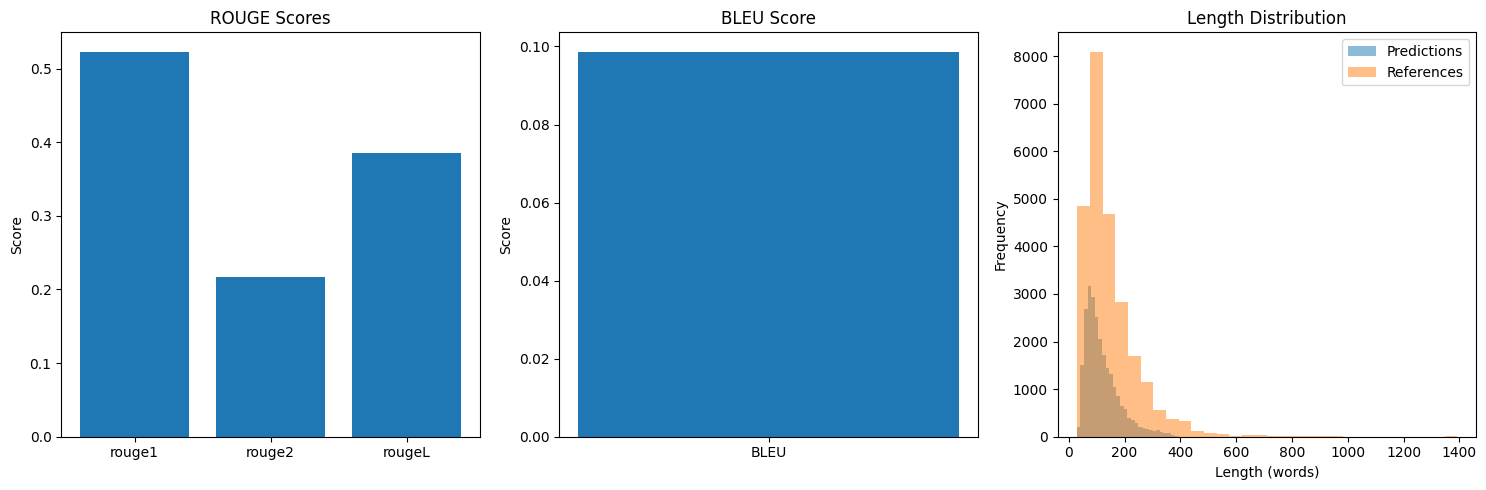


Detailed Metrics:
BLEU Score: 0.0987

Average ROUGE Scores:
rouge1: 0.5230
rouge2: 0.2168
rougeL: 0.3846


In [66]:



# Flatten the predicted lists
flattened_predicted = []
flattened_target = []
for preds, target in zip(df['predicted'], df['target']):
    for pred in preds:
        flattened_predicted.append(pred)
        flattened_target.append(target)

# Calculate metrics
bleu_score = calculate_bleu(flattened_target, flattened_predicted)
rouge_scores = calculate_rouge(flattened_target, flattened_predicted)

# Calculate average ROUGE scores
avg_rouge_scores = {
    'rouge1': np.mean([s['rouge1'].fmeasure for s in rouge_scores]),
    'rouge2': np.mean([s['rouge2'].fmeasure for s in rouge_scores]),
    'rougeL': np.mean([s['rougeL'].fmeasure for s in rouge_scores])
}

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: ROUGE Scores
plt.subplot(131)
plt.bar(avg_rouge_scores.keys(), avg_rouge_scores.values())
plt.title('ROUGE Scores')
plt.ylabel('Score')

# Plot 2: BLEU Score
plt.subplot(132)
plt.bar(['BLEU'], [bleu_score])
plt.title('BLEU Score')
plt.ylabel('Score')

# Plot 3: Length Distribution
plt.subplot(133)
pred_lengths = [len(pred.split()) for pred in flattened_predicted]
ref_lengths = [len(ref.split()) for ref in flattened_target]
plt.hist(pred_lengths, alpha=0.5, label='Predictions', bins=30)
plt.hist(ref_lengths, alpha=0.5, label='References', bins=30)
plt.title('Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics:")
print(f"BLEU Score: {bleu_score:.4f}")
print("\nAverage ROUGE Scores:")
for metric, score in avg_rouge_scores.items():
    print(f"{metric}: {score:.4f}")

C:\Users\darsh\AppData\Local\Temp\ipykernel_24700\64851657.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pred_lengths, ref_lengths], labels=['Predictions', 'References'])


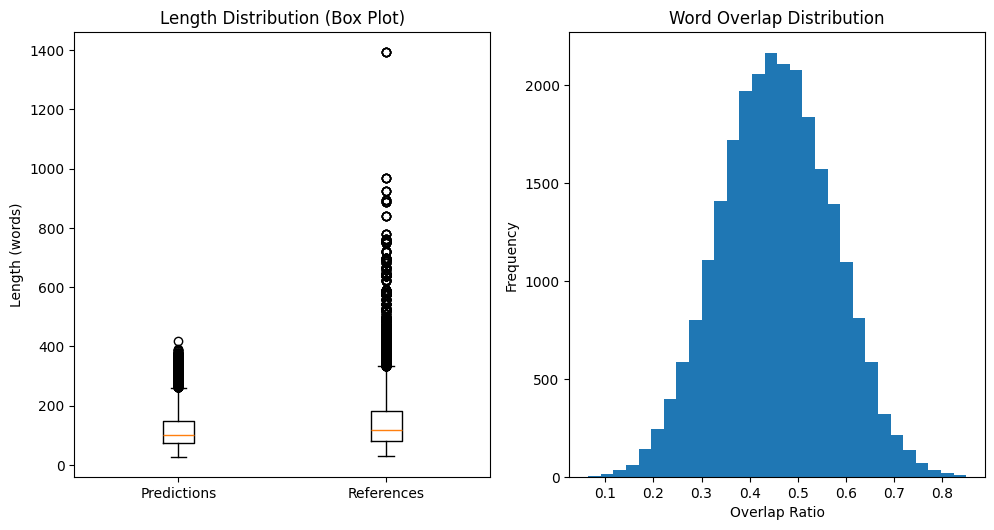

In [67]:
# Add more evaluation metrics
plt.figure(figsize=(15, 10))

# Original three plots
# ...existing code...

# Add new plots for more detailed analysis
plt.subplot(234)
plt.boxplot([pred_lengths, ref_lengths], labels=['Predictions', 'References'])
plt.title('Length Distribution (Box Plot)')
plt.ylabel('Length (words)')

plt.subplot(235)
# Calculate and plot word overlap
word_overlap = [len(set(pred.split()) & set(ref.split())) / len(set(ref.split()))
                for pred, ref in zip(flattened_predicted, flattened_target)]
plt.hist(word_overlap, bins=30)
plt.title('Word Overlap Distribution')
plt.xlabel('Overlap Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

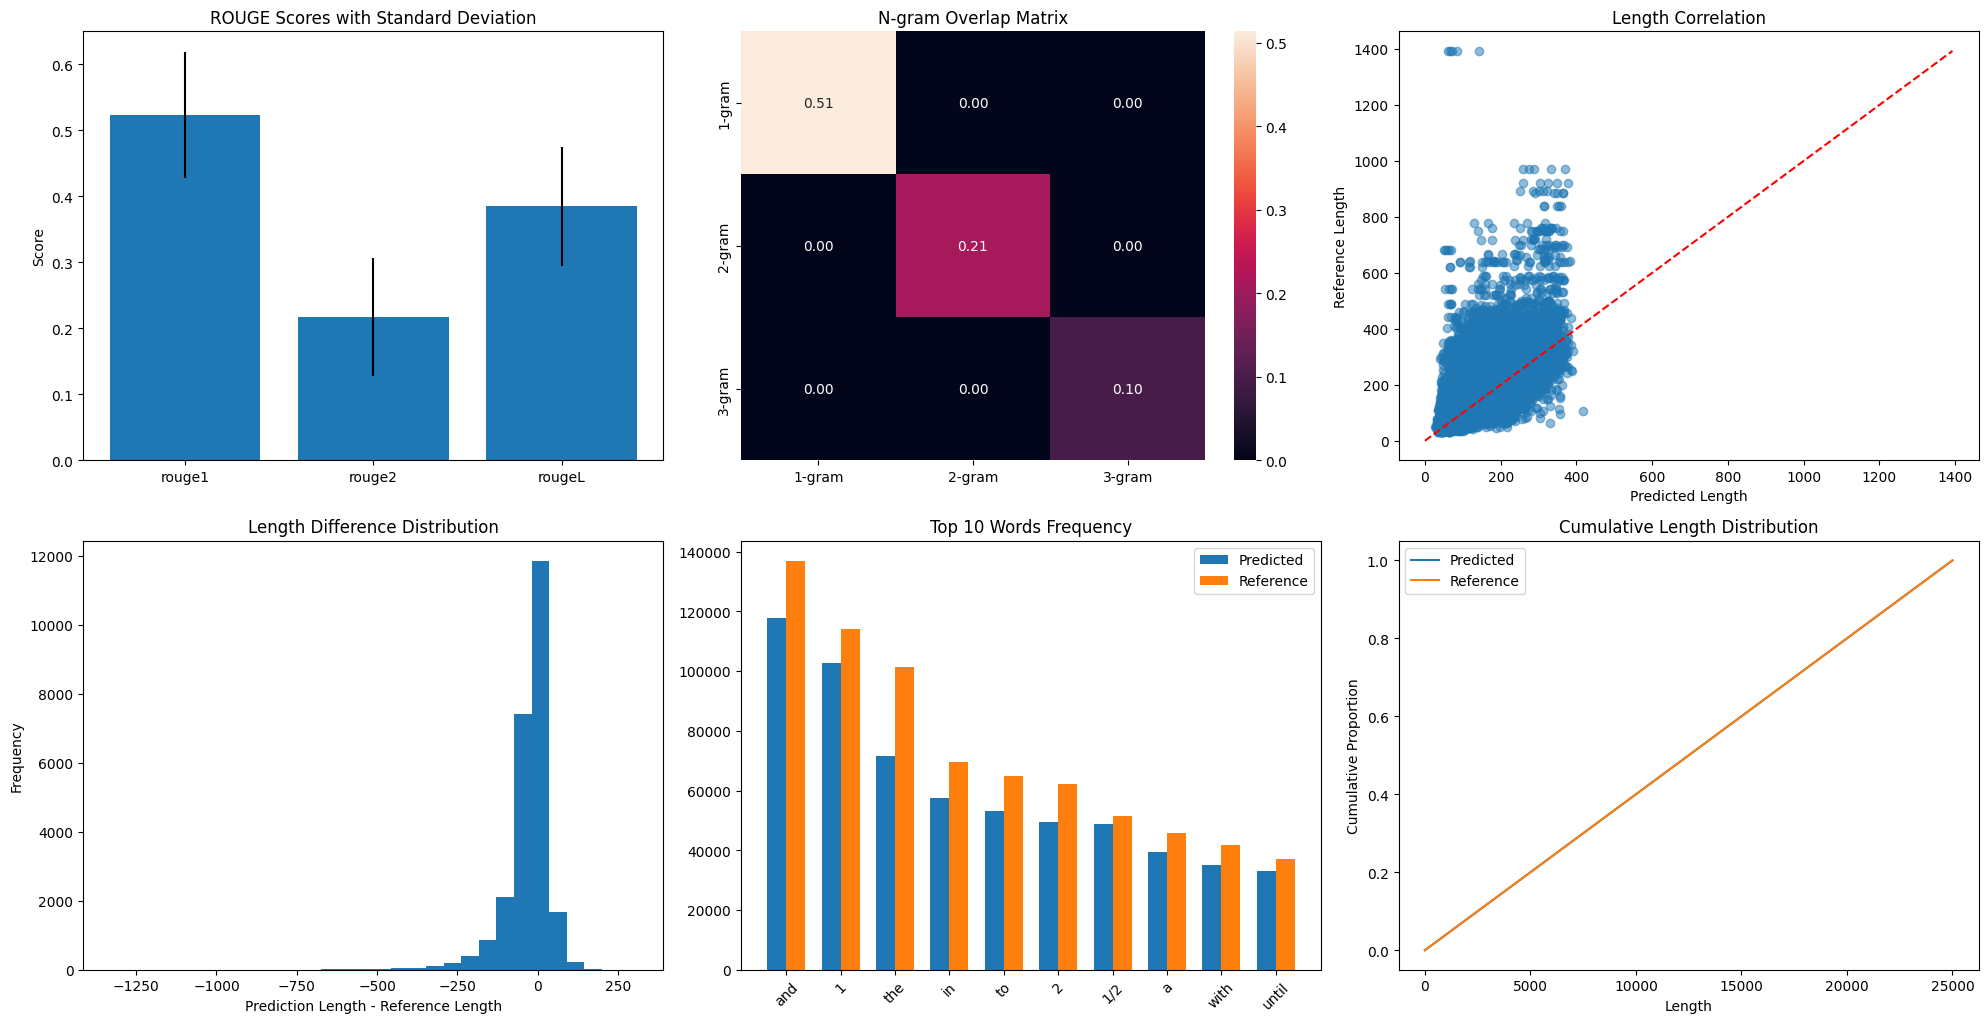


Additional Statistics:
Average prediction length: 119.82
Average reference length: 147.85
Length correlation coefficient: 0.69


In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a larger figure for multiple plots
plt.figure(figsize=(20, 15))

# 1. Original ROUGE Scores (enhanced with error bars)
plt.subplot(331)
rouge_std = {
    'rouge1': np.std([s['rouge1'].fmeasure for s in rouge_scores]),
    'rouge2': np.std([s['rouge2'].fmeasure for s in rouge_scores]),
    'rougeL': np.std([s['rouge2'].fmeasure for s in rouge_scores])
}
plt.bar(avg_rouge_scores.keys(), avg_rouge_scores.values(), yerr=list(rouge_std.values()))
plt.title('ROUGE Scores with Standard Deviation')
plt.ylabel('Score')

# 2. N-gram Overlap Heatmap
plt.subplot(332)
def get_ngrams(text, n):
    words = text.split()
    return set(' '.join(words[i:i+n]) for i in range(len(words)-n+1))

ngram_overlap = np.zeros((3,3))
for pred, ref in zip(flattened_predicted[:100], flattened_target[:100]):  # Sample first 100 for speed
    for i in range(3):
        for j in range(3):
            pred_ngrams = get_ngrams(pred, i+1)
            ref_ngrams = get_ngrams(ref, j+1)
            overlap = len(pred_ngrams & ref_ngrams) / len(ref_ngrams) if ref_ngrams else 0
            ngram_overlap[i,j] += overlap
ngram_overlap /= 100

sns.heatmap(ngram_overlap, annot=True, fmt='.2f', 
            xticklabels=['1-gram', '2-gram', '3-gram'],
            yticklabels=['1-gram', '2-gram', '3-gram'])
plt.title('N-gram Overlap Matrix')

# 3. Sentence Length Correlation
plt.subplot(333)
plt.scatter(pred_lengths, ref_lengths, alpha=0.5)
plt.plot([0, max(max(pred_lengths), max(ref_lengths))], 
         [0, max(max(pred_lengths), max(ref_lengths))], 
         'r--')
plt.xlabel('Predicted Length')
plt.ylabel('Reference Length')
plt.title('Length Correlation')

# 4. Length Difference Distribution
plt.subplot(334)
length_diffs = [p - r for p, r in zip(pred_lengths, ref_lengths)]
plt.hist(length_diffs, bins=30)
plt.title('Length Difference Distribution')
plt.xlabel('Prediction Length - Reference Length')
plt.ylabel('Frequency')

# 5. Word Frequency Comparison (Top 10 words)
plt.subplot(335)
from collections import Counter
def get_top_words(texts, n=10):
    words = [word for text in texts for word in text.lower().split()]
    return dict(Counter(words).most_common(n))

pred_words = get_top_words(flattened_predicted)
ref_words = get_top_words(flattened_target)

x = np.arange(10)
width = 0.35
plt.bar(x - width/2, list(pred_words.values()), width, label='Predicted')
plt.bar(x + width/2, list(ref_words.values()), width, label='Reference')
plt.xticks(x, list(pred_words.keys()), rotation=45)
plt.title('Top 10 Words Frequency')
plt.legend()

# 6. Cumulative Length Distribution
plt.subplot(336)
pred_lengths_sorted = sorted(pred_lengths)
ref_lengths_sorted = sorted(ref_lengths)
plt.plot(range(len(pred_lengths_sorted)), 
         [x/len(pred_lengths_sorted) for x in range(len(pred_lengths_sorted))],
         label='Predicted')
plt.plot(range(len(ref_lengths_sorted)), 
         [x/len(ref_lengths_sorted) for x in range(len(ref_lengths_sorted))],
         label='Reference')
plt.title('Cumulative Length Distribution')
plt.xlabel('Length')
plt.ylabel('Cumulative Proportion')
plt.legend()

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nAdditional Statistics:")
print(f"Average prediction length: {np.mean(pred_lengths):.2f}")
print(f"Average reference length: {np.mean(ref_lengths):.2f}")
print(f"Length correlation coefficient: {np.corrcoef(pred_lengths, ref_lengths)[0,1]:.2f}")

In [90]:
import os
import json
from colorama import Fore, Style

# Define the all_metrics dictionary
all_metrics = {
    "cosine_similarity": cosim_score,
    "rouge": rouge_score,
    "bleu": bleu_score,
    "gleu": gleu_score,
    "meteor": m_score
}

# Save all metrics to a file
output_dir = "output_chef_transformer"
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "metrics.json"), "w") as f:
    json.dump(all_metrics, f, indent=2)
print(f"{Fore.GREEN}✓{Style.RESET_ALL} Metrics saved to {os.path.join(output_dir, 'metrics.json')}")

# Define the print_section function
def print_section(title):
    print(f"\n{'='*len(title)}\n{title}\n{'='*len(title)}\n")

# Define the ascii_bar_chart function
def ascii_bar_chart(values, labels, title):
    max_len = max(len(label) for label in labels)
    max_value = max(values)
    scale = 50 / max_value
    print(f"\n{title}\n")
    for label, value in zip(labels, values):
        bar = '#' * int(value * scale)
        print(f"{label.ljust(max_len)} | {bar} {value:.2f}")

# Visualization: ASCII bar chart of metrics
print_section("Metric Visualizations")

# Bar chart for all metrics
metric_names = ["Cosine Sim", "ROUGE", "BLEU", "GLEU", "METEOR"]
metric_values = [all_metrics["cosine_similarity"], all_metrics["rouge"], 
                 all_metrics["bleu"], all_metrics["gleu"], all_metrics["meteor"]]

ascii_bar_chart(metric_values, metric_names, "Comparison of Metrics (higher is better)")


✓ Metrics saved to output_chef_transformer\metrics.json

Metric Visualizations


Comparison of Metrics (higher is better)

Cosine Sim | ################################################## 0.73
ROUGE      | ################## 0.27
BLEU       | ###### 0.10
GLEU       | ################## 0.26
METEOR     | ################################# 0.49


In [92]:
# Distribution charts for each metric (using histogram)
for metric_name, scores in [
    ("Cosine Similarity", cosim_scores),
    ("WER", wer_scores),
    ("ROUGE", [score['rouge2'].fmeasure if isinstance(score['rouge2'], dict) else score['rouge2'] for score in rouge_scores]),
    ("BLEU", bleu_scores),
    ("GLEU", gleu_scores),
    ("METEOR", m_scores)
]:
    print(f"\n{Fore.CYAN}Distribution of {metric_name} scores:{Style.RESET_ALL}")
    
    # Calculate histogram data
    hist, bin_edges = np.histogram(scores, bins=10)
    
    # Print ASCII histogram
    max_count = max(hist)
    for i in range(len(hist)):
        bar_length = int((hist[i] / max_count) * 30)
        print(f"{bin_edges[i]:.3f} - {bin_edges[i+1]:.3f} | {'█' * bar_length} {hist[i]}")



Distribution of Cosine Similarity scores:
0.292 - 0.357 |  9
0.357 - 0.422 |  21
0.422 - 0.487 | █ 68
0.487 - 0.552 | ████ 199
0.552 - 0.617 | █████████ 403
0.617 - 0.682 | ██████████████████ 793
0.682 - 0.747 | █████████████████████████ 1093
0.747 - 0.811 | ██████████████████████████████ 1283
0.811 - 0.876 | ██████████████████████ 943
0.876 - 0.941 | ████ 188

Distribution of WER scores:
0.329 - 0.484 |  31
0.484 - 0.640 | █████ 477
0.640 - 0.795 | ██████████████████████████████ 2634
0.795 - 0.950 | ████████████████████ 1756
0.950 - 1.106 |  79
1.106 - 1.261 |  15
1.261 - 1.417 |  4
1.417 - 1.572 |  1
1.572 - 1.728 |  2
1.728 - 1.883 |  1

Distribution of ROUGE scores:
0.000 - 0.070 | ███ 2294
0.070 - 0.140 | █████████████████ 12993
0.140 - 0.210 | ██████████████████████████████ 21707
0.210 - 0.281 | ██████████████████████████ 19347
0.281 - 0.351 | ███████████████ 11410
0.351 - 0.421 | ██████ 4990
0.421 - 0.491 | ██ 1681
0.491 - 0.561 |  452
0.561 - 0.631 |  102
0.631 - 0.701 |  24



In [93]:

# Calculate statistical measures
stats_data = []
for name, values in [
    ("Cosine Similarity", cosim_scores),
    ("WER", wer_scores),
    ("ROUGE", [score['rouge2'].fmeasure if isinstance(score['rouge2'], dict) else score['rouge2'] for score in rouge_scores]),
    ("BLEU", bleu_scores),
    ("GLEU", gleu_scores),
    ("METEOR", m_scores)
]:
    values_array = np.array(values)
    stats = {
        "Metric": name,
        "Mean": values_array.mean(),
        "Median": np.median(values_array),
        "Std Dev": values_array.std(),
        "Min": values_array.min(),
        "Max": values_array.max()
    }
    stats_data.append(stats)

In [94]:
# Score statistics
print_section("Score Statistics")

# Print statistics table
print(f"{'Metric':<20} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)
for stat in stats_data:
    print(f"{stat['Metric']:<20} {stat['Mean']:<10.4f} {stat['Median']:<10.4f} {stat['Std Dev']:<10.4f} {stat['Min']:<10.4f} {stat['Max']:<10.4f}")

# Sample comparisons (show a few examples of target vs. predicted)
print_section("Sample Comparisons")



Score Statistics

Metric               Mean       Median     Std Dev    Min        Max       
----------------------------------------------------------------------
Cosine Similarity    0.7280     0.7413     0.1014     0.2924     0.9412    
WER                  0.7610     0.7692     0.0998     0.3286     1.8833    
ROUGE                0.2215     0.2118     0.0945     0.0000     0.7015    
BLEU                 0.3262     0.3198     0.1250     0.0260     0.8018    
GLEU                 0.2632     0.2567     0.0795     0.0282     0.6861    
METEOR               0.4900     0.4825     0.0830     0.1753     0.8419    

Sample Comparisons



In [95]:

# Show a few examples from the dataset
sample_indices = np.random.choice(len(df), size=3, replace=False)
for i, idx in enumerate(sample_indices):
    print(f"\n{Fore.CYAN}Example {i+1}:{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Input:{Style.RESET_ALL} {df['input'][idx]}")
    print(f"{Fore.YELLOW}Target Title:{Style.RESET_ALL} {df['target'][idx].split('ingredients:')[0]}")
    print(f"{Fore.YELLOW}Predicted Title:{Style.RESET_ALL} {df['predicted'][idx][0].split('ingredients:')[0]}")
    
    print(f"\n{Fore.YELLOW}Scores for this example:{Style.RESET_ALL}")
    target = df['target'][idx]
    predicted = df['predicted'][idx][0]
    
    # Calculate individual scores for this example
    target_tokens = wordpunct_tokenize(target)
    predicted_tokens = wordpunct_tokenize(predicted)
    
    example_scores = {
        "Cosine Similarity": get_result(target, predicted),
        "WER": wer.compute(references=[target], predictions=[predicted]),
        "BLEU": compute_bleu(target_tokens, [predicted_tokens]),
        "GLEU": compute_gleu(target_tokens, [predicted_tokens]),
        "METEOR": compute_meteor(target_tokens, [predicted_tokens])
    }
    
    for metric, score in example_scores.items():
        print(f"  - {metric}: {score:.4f}")



Example 1:
Input: lentils, long grain brown rice, chicken broth, water, clove garlic, onion, celery, stalks parsley, black pepper, basil, oregano, bay leaf, lemon, carrots, red potatoes
Target Title: title: hearty rice and lentil stew recipe 
Predicted Title: title: lentil and brown rice soup recipe 

Scores for this example:
  - Cosine Similarity: 0.7673
  - WER: 0.7843
  - BLEU: 0.1942
  - GLEU: 0.2561
  - METEOR: 0.4289

Example 2:
Input: chocolate, butter, granulated sugar, eggs, vanilla, flour, nuts
Target Title: title: baker s one bowl truffle torte 
Predicted Title: title: brownies 

Scores for this example:
  - Cosine Similarity: 0.5579
  - WER: 0.8284
  - BLEU: 0.1347
  - GLEU: 0.1845
  - METEOR: 0.4060

Example 3:
Input: very ripe plums, garlic, onion, white sugar, apple cider vinegar, garlic, pepper, salt, liquid smoke flavoring, canning jars with
Target Title: title: plum chipotle sauce 
Predicted Title: title: plum pickled garlic 

Scores for this example:
  - Cosine Simi

In [96]:
print_section("Summary")

# Define total_samples
total_samples = len(dataset)

# Calculate VRAM used by the model (set to 0 for CPU)
used_by_model = 0

# Print a final summary
print(f"Processed {len(df)} valid samples out of {total_samples} total samples")
print(f"Model: {model_name_or_path}")
print(f"Device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")
print(f"VRAM Used: {used_by_model:.2f} GB")
print("\nOverall metrics:")

for name, value in all_metrics.items():
    print(f"  - {name}: {value:.4f}")

print(f"\nResults and metrics saved to {os.path.join('output_chef_transformer')}")
print(f"\n{Fore.GREEN}Evaluation completed successfully!{Style.RESET_ALL}")


Summary

Processed 5000 valid samples out of 5000 total samples
Model: flax-community/t5-recipe-generation
Device: cpu (CPU)
VRAM Used: 0.00 GB

Overall metrics:
  - cosine_similarity: 0.7280
  - rouge: 0.2662
  - bleu: 0.0987
  - gleu: 0.2632
  - meteor: 0.4900

Results and metrics saved to output_chef_transformer

Evaluation completed successfully!
